In [52]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import torch
    
import pandas as pd

import numpy as np

from sklearn.metrics import mean_squared_error
import seaborn as sns

In [3]:
train = pd.read_csv('Dataset/train.csv')
train.head()

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,type2,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,...,type2,1.0,4,-0.9612,-0.4537,3.0,3,8,3,0.0851
3,EID_17492,F,26.0,3,Single,Lebanon,Human Resource Management,Behavioral,4.0,3,...,type2,1.0,3,-1.8176,-0.4537,NaN,3,7,3,0.0668
4,EID_22534,F,31.0,1,Married,Springfield,Logistics,Conceptual,5.0,4,...,type3,3.0,1,0.7516,-0.4537,2.0,2,8,2,0.1827


In [4]:
# Make all of the data numerical 
def handle_non_numerical_data(df, categorical):
    new_df = pd.get_dummies(df, columns=categorical)
    new_df.drop(['Employee_ID'], axis=1, inplace=True)
    return new_df
    
categorical = ['Hometown','Gender','Relationship_Status','Decision_skill_possess','Unit','Compensation_and_Benefits']
df = handle_non_numerical_data(train,categorical)
df.head()

,Age,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,...,Unit_Purchasing,Unit_Quality,Unit_R&D,Unit_Sales,Unit_Security,Compensation_and_Benefits_type0,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4
0,42.0,4,4.0,4,33,1,1,7.0,3.0,4,...,0,0,0,0,0,0,0,1,0,0
1,24.0,3,5.0,4,36,0,3,6.0,4.0,3,...,0,0,0,0,0,0,0,1,0,0
2,58.0,3,27.0,3,51,0,2,8.0,1.0,4,...,0,1,0,0,0,0,0,1,0,0
3,26.0,3,4.0,3,56,1,3,8.0,1.0,3,...,0,0,0,0,0,0,0,1,0,0
4,31.0,1,5.0,4,62,1,3,2.0,3.0,1,...,0,0,0,0,0,0,0,0,1,0


In [5]:
# Fill NA values with averages
# May have to fix to be better with one hot encoding
def fill_na(df):
    mean = df.mean(axis=0)
    df.fillna(value=mean, inplace=True)
    
    return df

df = fill_na(df)
df.tail()

,Age,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,...,Unit_Purchasing,Unit_Quality,Unit_R&D,Unit_Sales,Unit_Security,Compensation_and_Benefits_type0,Compensation_and_Benefits_type1,Compensation_and_Benefits_type2,Compensation_and_Benefits_type3,Compensation_and_Benefits_type4
6995,23.0,5,4.0,1,20,1,2,6.0,3.0,1,...,0,0,0,0,0,0,0,0,1,0
6996,44.0,1,16.0,2,59,0,2,4.0,3.0,2,...,0,0,1,0,0,0,0,0,1,0
6997,49.0,3,10.0,1,59,1,2,3.0,4.0,2,...,0,0,0,0,0,0,0,1,0,0
6998,47.0,3,24.0,1,21,1,5,8.0,2.0,4,...,0,0,0,1,0,1,0,0,0,0
6999,58.0,3,22.0,2,74,0,4,5.0,3.0,3,...,0,0,0,0,0,0,0,1,0,0


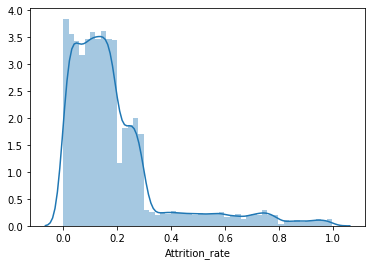

In [63]:
sns.distplot(train.Attrition_rate)

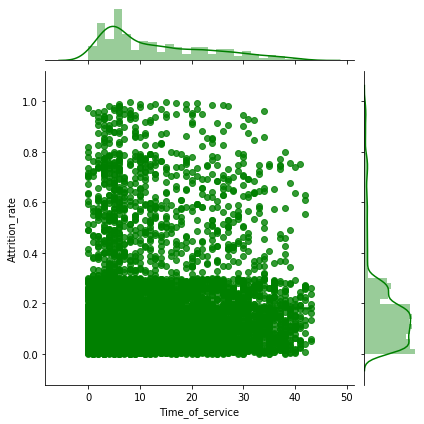

In [62]:
sns.jointplot(data=train, x='Time_of_service', y='Attrition_rate', kind='reg', color='g')
plt.show()

In [20]:
# Seperate into independent and dependent variable
X = df.iloc[:,:-1]
y = df.iloc[:,df.columns.get_loc('Attrition_rate')]

X = torch.from_numpy(X.values)
y = torch.from_numpy(y.values.reshape(-1,1))

X_train, X_test, y_train, y_test =  [Variable(x) for x in train_test_split(X,y,test_size = 0.2, random_state= 0)]

# Define the network
model = nn.Sequential(
    nn.Linear(46, 200),
    nn.LeakyReLU(),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.Linear(100, 1),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

BATCH_SIZE = 64
EPOCH = 200

torch_dataset = Data.TensorDataset(X_train,y_train)

loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2,)

In [21]:
# Training
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        
        prediction = model(b_x.float())
        
        loss = loss_func(prediction.double(), b_y)
        if step == 1:
            print('{} loss: {}'.format(epoch, loss))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

0 loss: 97.35467751660426
1 loss: 0.027068282530312376
2 loss: 0.028933331342167815
3 loss: 0.01046960453014021
4 loss: 0.014049895687762992
5 loss: 0.0021606537434505062
6 loss: 6.506622394668573e-05
7 loss: 0.00011081504362586012
8 loss: 5.1947472577057025e-05
9 loss: 6.0639028633769496e-05
10 loss: 0.0002467744083333261
11 loss: 0.0005569945683867614
12 loss: 0.0013252821842105406
13 loss: 8.510843166927559e-06
14 loss: 4.166140292577517e-06
15 loss: 0.00011899985655951448
16 loss: 2.0130975711621025e-05
17 loss: 2.1314030042182297e-05
18 loss: 0.0005331575568875161
19 loss: 0.001287068040867628
20 loss: 0.00011531497387830622
21 loss: 8.946385982393284e-05
22 loss: 6.508536137603082e-06
23 loss: 0.0016972815137165438
24 loss: 4.953121031587594e-05
25 loss: 1.3777037270715616e-05
26 loss: 0.00018392648985804925
27 loss: 1.3799170283270612e-05
28 loss: 7.2019890834573285e-06
29 loss: 8.053255646145836e-06
30 loss: 0.00010998633216942102
31 loss: 1.6115782720541028e-05
32 loss: 1.1200

In [51]:
y_pred=model(X_test.float())